<a href="https://colab.research.google.com/github/samitroy-utexas/AI395T/blob/main/Self_Learning_Project_sr56764.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages in Google Colab
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import gc
from scipy.sparse import csr_matrix, hstack
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Connect to Google Drive to read in the files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the data
admissions = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/ADMISSIONS.csv', low_memory=False).set_index('ROW_ID')
patients = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/PATIENTS.csv', low_memory=False).set_index('ROW_ID')
lab_events = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/LABEVENTS.csv', low_memory=False).set_index('ROW_ID')
diagnoses_icd = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv', low_memory=False).set_index('ROW_ID')
prescriptions = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv', low_memory=False).set_index('ROW_ID')

Mounted at /content/drive


In [ ]:
# Filter LABEVENTS for creatinine measurements (ITEMID = 50912)
creatinine_events = lab_events[lab_events['ITEMID'] == 50912]

# Merge patients and admissions on SUBJECT_ID
merged_df = pd.merge(patients, admissions, on='SUBJECT_ID', how='inner')

# Merge with diagnoses_icd on HADM_ID
merged_df = pd.merge(merged_df, diagnoses_icd, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Merge with creatinine_events on HADM_ID
merged_df = pd.merge(merged_df, creatinine_events, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Drop unwanted columns
merged_df.drop(columns=['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'EDREGTIME', 'EDOUTTIME',
                'DOD',  'DOD_HOSP', 'DOD_SSN'], inplace=True)

# Drop duplicates
merged_df.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'],inplace=True, keep='first')

# Inspect
merged_df.head()
print(list(merged_df))
print(merged_df.info())
print(len(merged_df))

['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG', 'HADM_ID', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'SEQ_NUM', 'ICD9_CODE', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM', 'FLAG']
<class 'pandas.core.frame.DataFrame'>
Index: 50998 entries, 0 to 9206749
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SUBJECT_ID            50998 non-null  int64  
 1   GENDER                50998 non-null  object 
 2   DOB                   50998 non-null  object 
 3   EXPIRE_FLAG           50998 non-null  int64  
 4   HADM_ID               50998 non-null  int64  
 5   ADMISSION_TYPE        50998 non-null  object 
 6   INSURANCE             50998 non-null  object 
 7   RELIGION              50545 non-null  object 
 8   MARITAL_STATUS        47865 non-null  object 
 9   ETHNICITY             50998 non-null  object 
 

In [ ]:
# ICD-9 codes for kidney disease
kidney_disease_icd9_codes = [
    '5851', '5852', '5853', '5854', '5855', '5856', '5859',  # Chronic Kidney Disease (CKD)
    '5845', '5846', '5847', '5848', '5849',                    # Acute Kidney Failure
    '5829', '58381', '5939'                                      # Other Kidney Conditions
]

# Filter DIAGNOSES_ICD for kidney disease-related codes
diagnoses_kidney_disease = diagnoses_icd[diagnoses_icd['ICD9_CODE'].isin(kidney_disease_icd9_codes)]

print(diagnoses_kidney_disease.head())
print(len(diagnoses_kidney_disease))

# Merge with prescriptions data for Kidney Disease
kidney_disease_prescriptions = pd.merge(prescriptions, diagnoses_kidney_disease, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

print(kidney_disease_prescriptions.head())
print(len(kidney_disease_prescriptions))


        SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
ROW_ID                                        
1300           109   172335      4.0      5855
1312           109   173633      2.0      5856
1313           109   173633      3.0     58381
1506           115   114585      5.0      5845
1535           117   164853      4.0      5849
19437
   SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTDATE              ENDDATE  \
0           9   150750         NaN  2149-11-09 00:00:00  2149-11-09 00:00:00   
1           9   150750         NaN  2149-11-09 00:00:00  2149-11-09 00:00:00   
2           9   150750         NaN  2149-11-09 00:00:00  2149-11-09 00:00:00   
3           9   150750         NaN  2149-11-09 00:00:00  2149-11-09 00:00:00   
4           9   150750         NaN  2149-11-09 00:00:00  2149-11-09 00:00:00   

  DRUG_TYPE                DRUG       DRUG_NAME_POE   DRUG_NAME_GENERIC  \
0      BASE                  SW                 NaN                 NaN   
1      MAIN       Labetalol HCl   

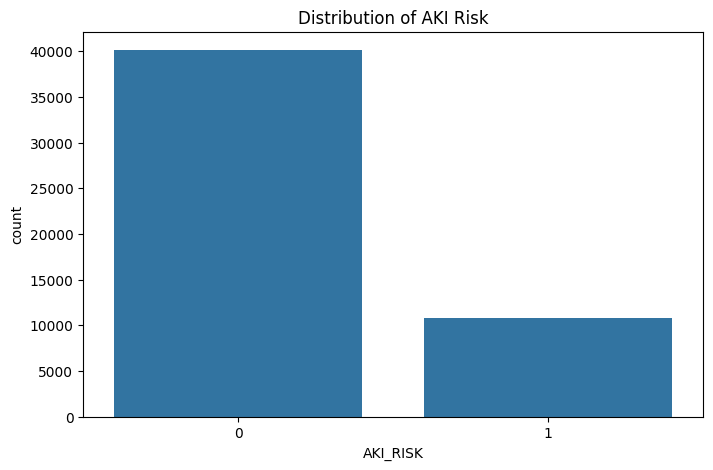

In [ ]:
# Handle missing values
merged_df['VALUENUM'] = merged_df['VALUENUM'].fillna(merged_df['VALUENUM'].median())

# Calculate AKI risk based on creatinine levels (> 1.5 is considered Kidney Damage)
merged_df['AKI_RISK'] = (merged_df['VALUENUM'] > 1.5).astype(int)  # AKI_RISK to have 0 if < 1.5 and 1 if > 1.5

# Visualize the distribution of how many patients with Creatinine > 1.5 and < 1.5
plt.figure(figsize=(8, 5))
sns.countplot(x='AKI_RISK', data=merged_df)
plt.title('Distribution of AKI Risk')
plt.show()

# Merging with prescriptions data
merged_df = pd.merge(merged_df, kidney_disease_prescriptions, on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Remove unwanted columns that will not be much use during training
merged_df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'STARTDATE', 'ENDDATE', 'FLAG', 'GSN', 'DOB', 'SEQ_NUM_y', 'ICD9_CODE_y'], inplace=True)

# Function to remove special characters from strings
def remove_special_chars(text):
    if isinstance(text, str):
        return ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

# Remove special characters from columns
merged_df = merged_df.apply(lambda col: col.map(remove_special_chars))

# Handle NaNs
merged_df.ffill(inplace=True)

# Handle missing values for numerical columns
numerical_cols = merged_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32', 'int16', 'int8']).columns
merged_df[numerical_cols] = merged_df[numerical_cols].fillna(merged_df[numerical_cols].median())

# Drop any remaining rows with missing values
merged_df.dropna(inplace=True)

# Identify numerical columns
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns

# Scale numerical features
scaler = StandardScaler()
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

# Calculate AKI risk based on creatinine levels again to make doubly sure all rows have been covered
merged_df['AKI_RISK'] = (merged_df['VALUENUM'] > 1.5).astype(int)

# Save the resulting DataFrame to a CSV file
merged_df.to_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/merged_data.csv', index=True)


In [ ]:
# Inspect the data
print(list(merged_df))
print(merged_df.info())
pd.set_option('display.max_columns', None)
print(merged_df.head())
print(len(merged_df))

['GENDER', 'EXPIRE_FLAG', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'SEQ_NUM_x', 'ICD9_CODE_x', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'AKI_RISK', 'ICUSTAY_ID', 'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC', 'FORMULARY_DRUG_CD', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107003 entries, 0 to 2107002
Data columns (total 30 columns):
 #   Column                Dtype  
---  ------                -----  
 0   GENDER                object 
 1   EXPIRE_FLAG           float64
 2   ADMISSION_TYPE        object 
 3   INSURANCE             object 
 4   RELIGION              object 
 5   MARITAL_STATUS        object 
 6   ETHNICITY             object 
 7   DIAGNOSIS             object 
 8   HOSPITAL_EXPIRE_FLAG  float64
 9   HAS_CHARTEVENTS_DATA  float64
 10  SEQ_NUM_x             flo

In [ ]:
# Load in case of disconnection or crash during training so that we don't have to do the data preprocessing again
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import gc
from scipy.sparse import csr_matrix, hstack
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Connect to Google Drive to read in the files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the data
merged_df = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/merged_data.csv', low_memory=False)

Mounted at /content/drive


In [ ]:
# Hot Encode String Columns

import pandas as pd

# List of categorical columns
categorical_cols = [
    'GENDER', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'VALUEUOM', 'DRUG_TYPE',
    'DIAGNOSIS', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC', 'PROD_STRENGTH',
    'DOSE_UNIT_RX', 'FORMULARY_DRUG_CD', 'FORM_UNIT_DISP', 'SEQ_NUM_x',
    'ICD9_CODE_x', 'VALUE', 'DOSE_VAL_RX', 'FORM_VAL_DISP', 'ROUTE',
    'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER'
]

# Fill missing values with 'Unknown'
for col in categorical_cols:
    merged_df[col] = merged_df[col].fillna('Unknown')

# Apply one-hot encoding with sparse=True
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

# Inspect the data
print(merged_df.info())
print(len(merged_df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107003 entries, 0 to 2107002
Columns: 34262 entries, Unnamed: 0 to GENDER_M
dtypes: bool(34253), float64(7), int64(2)
memory usage: 67.4 GB
None
2107003


In [ ]:
# Work on a smaller data sample since we don't have enough RAM/GPU to consider the entire dataset
merged_df = merged_df.sample(frac=0.05, random_state=42)
print(merged_df.info())
print(len(merged_df))

<class 'pandas.core.frame.DataFrame'>
Index: 105350 entries, 1223612 to 1050249
Columns: 34262 entries, Unnamed: 0 to GENDER_M
dtypes: bool(34253), float64(7), int64(2)
memory usage: 3.4 GB
None
105350


GradientBoostingClassifier done.
RandomForestClassifier done.
                            Accuracy       AUC
GradientBoostingClassifier   1.00000  1.000000
RandomForestClassifier       0.97888  0.999984


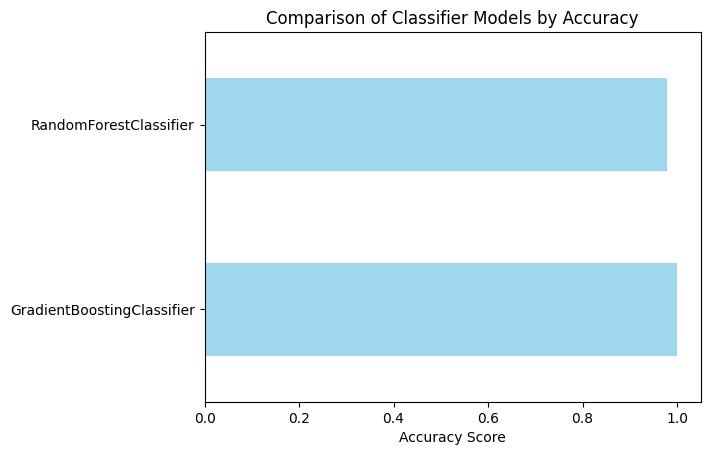

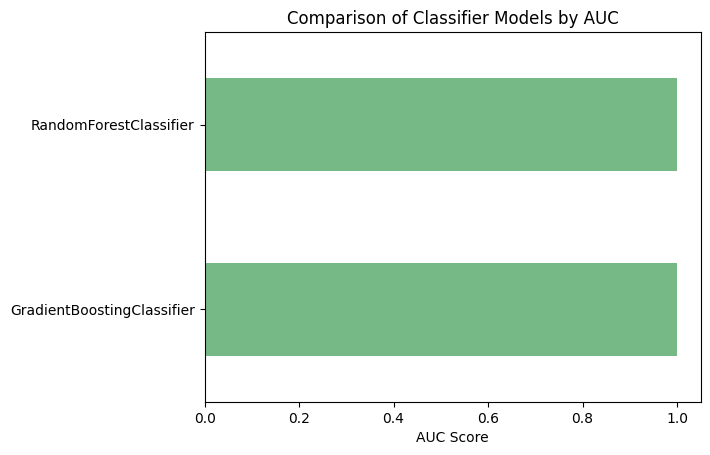

In [ ]:
# USE OUT OF BOX MODELS TO SEE HOW THEY PERFORM
# Define features and target
X = merged_df.drop('AKI_RISK', axis=1)
y = merged_df['AKI_RISK']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define models to train
models = [
          GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
          RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=0)
         ]

results = {}

for model in models:
    # Train model
    clf = model
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy and AUC score
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    # Store results
    name = model.__class__.__name__
    if isinstance(model, LogisticRegression):
        name += f" ({model.solver})"
    results[name] = {'Accuracy': accuracy, 'AUC': auc_score}
    print(f'{name} done.')

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

# Plot Accuracy
results_df['Accuracy'].plot(kind='barh', color='skyblue', alpha=0.8)
plt.title('Comparison of Classifier Models by Accuracy')
plt.xlabel('Accuracy Score')
plt.show()

# Plot AUC scores
results_df['AUC'].plot(kind='barh', color='#55a868', alpha=0.8)
plt.title('Comparison of Classifier Models by AUC')
plt.xlabel('AUC Score')
plt.show()


Using device: cpu
Epoch [10/50], Train Loss: 0.0036, Test Loss: 0.0062, Train Acc: 0.9993, Test Acc: 0.9987
Epoch [20/50], Train Loss: 0.0022, Test Loss: 0.0077, Train Acc: 0.9996, Test Acc: 0.9994
Epoch [30/50], Train Loss: 0.0068, Test Loss: 0.0015, Train Acc: 0.9991, Test Acc: 0.9996
Epoch [40/50], Train Loss: 0.0164, Test Loss: 0.0046, Train Acc: 0.9963, Test Acc: 0.9992
Epoch [50/50], Train Loss: 0.0031, Test Loss: 0.0020, Train Acc: 0.9993, Test Acc: 0.9997


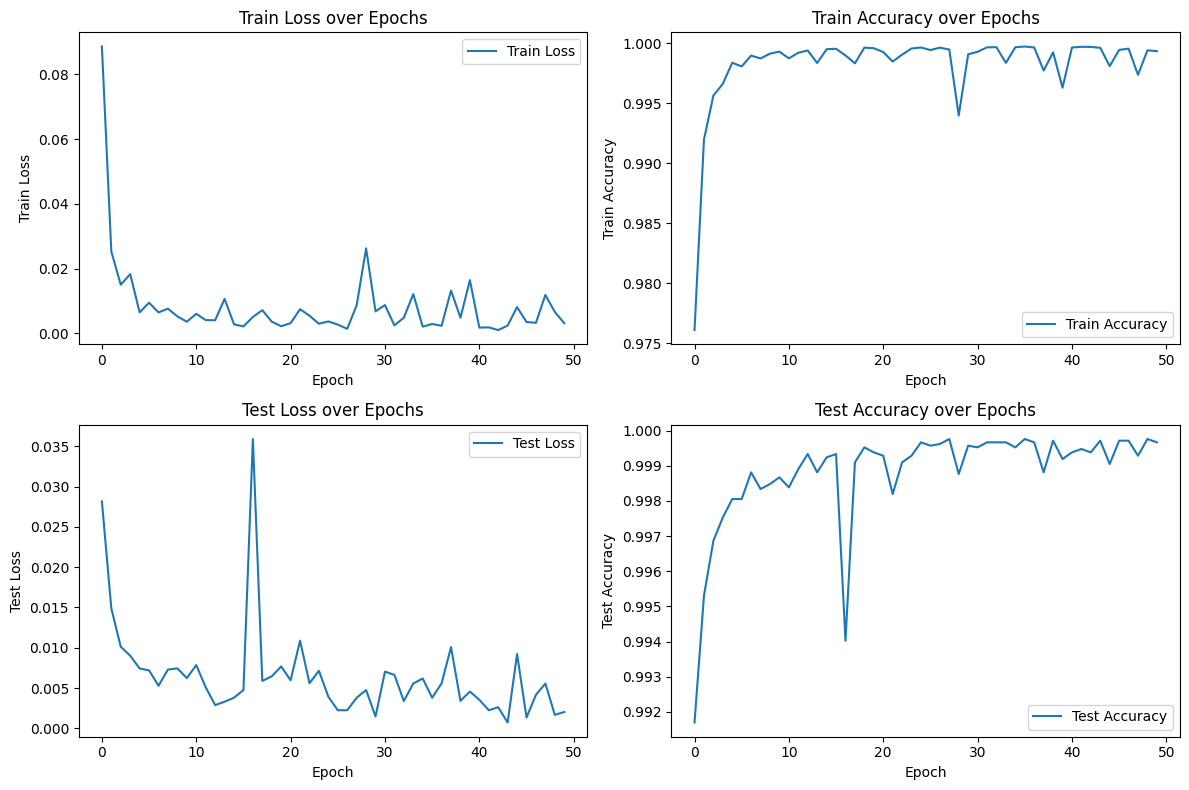

Test Accuracy: 1.00
Test AUC: 1.00


In [ ]:
# CREATE OUR OWN NEURAL NETWORK AND MODEL TO TRAIN AND CLASSIFY

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define features and target
#X = torch.tensor(merged_df.drop('AKI_RISK', axis=1).values, dtype=torch.float32)
#y = torch.tensor(merged_df['AKI_RISK'].values, dtype=torch.float32)

X = merged_df.drop('AKI_RISK', axis=1).values
y = merged_df['AKI_RISK'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define PyTorch Dataset
class AKIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.astype(np.float32), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = AKIDataset(X_train, y_train)
test_dataset = AKIDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the model
class AKIModel(nn.Module):
    def __init__(self, input_dim):
        super(AKIModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Instantiate the model, define loss function and optimizer
model = AKIModel(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')

# Plot training and test loss and accuracy
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Train Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Train Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        y_pred.extend(outputs.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

# Calculate accuracy and AUC
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]
accuracy = accuracy_score(y_true, y_pred_binary)
auc_score = roc_auc_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test AUC: {auc_score:.2f}')